In [1]:
try:
  from utils import install_packages, interactive_pairplot
except:
  # Colab
  !git clone https://github.com/mackelab/simformer.git
  from simformer.example.utils import install_packages, interactive_pairplot
  from google.colab import output
  output.enable_custom_widget_manager()

In [2]:
# This can run for 4 min if nothing is installed/has to be down/upgraded
install_packages() # install required packages if necessary, might requires restarting the kernel/colab runtime

In [3]:
import jax
import jax.numpy as jnp
import os
print(jax.devices()) # Should be cuda
_ = os.system("nvidia-smi  --query-gpu=name --format=csv,noheader") # Should show GPU info

[cuda(id=0)]
NVIDIA GeForce RTX 3050 Laptop GPU


In [4]:
from scoresbibm.utils.data_utils import load_model

import matplotlib.pyplot as plt
import numpy as np

from sbi.analysis import pairplot


# SLCP example 

This is a simple example of a SLCP model (simple likelihood complex posterior) benchmark model. 

### 1) Loading model and sample

In [5]:
PATH = "../results/example_guidance" if os.path.exists("../results/example_guidance") else "simformer/results/example_guidance"
model = load_model(PATH, 2)

In [6]:
condition_mask = jnp.array([False]*5 + [True]*8)
x_o = jnp.array([0.,-1.,-8.,0.,-3.,0.,-1.,-1.,-1])

In [7]:
# Models are convenience wrappers around functions to match the sbi API, they do not necessarily support full jit and might not be super efficient
@jax.jit
def sample_fn(rng, condition_mask, x_o):
  samples1 = model.sample(3000, condition_mask=condition_mask, x_o=x_o, rng=rng, num_steps=100, unique_nodes=True, return_conditioned_samples=True)
  return samples1


In [8]:
samples = sample_fn(jax.random.PRNGKey(2), condition_mask, x_o) # Compile time

In [9]:
%%timeit 
sample_fn(jax.random.PRNGKey(2), condition_mask, x_o)

1.98 s ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


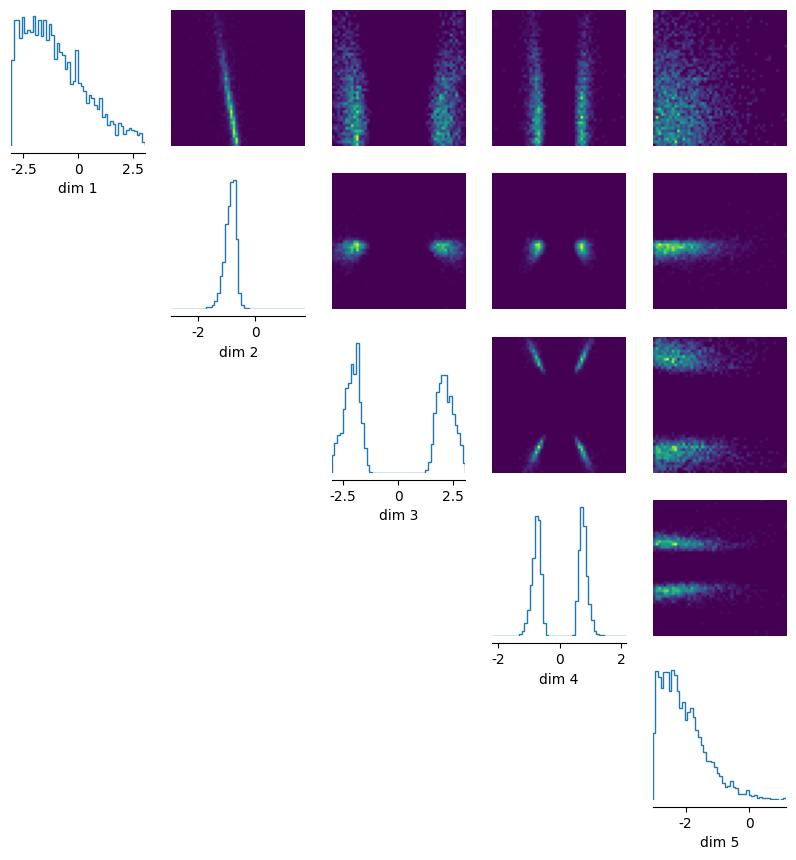

In [10]:
# Posterior samples
_ = pairplot(np.array(samples[:,~condition_mask]))

### 2) Interactive Pairplot

To better understand and explore the model's behavior under various conditions, we utilize an interactive pairplot. This tool allows us to condition on different variables by interacting directly with the plot.

You can *click on any diagonal plot to set a condition value of a variable*. The pairplot will update to show the conditional distribution based on your selection. This interactive feature is particularly useful for exploring how the model performs under both typical (well-specified) and edge-case scenarios (i.e. miss-specified). In the papaer we only evaluate the model under well-specified conditions.

To remove a condition, simply click on the diagonal (it will upadte the plot by removing the condition).

In [11]:
lowers = np.array([-3.]*5 + [-15.]*8)
uppers = np.array([3.]*5 + [15.]*8)

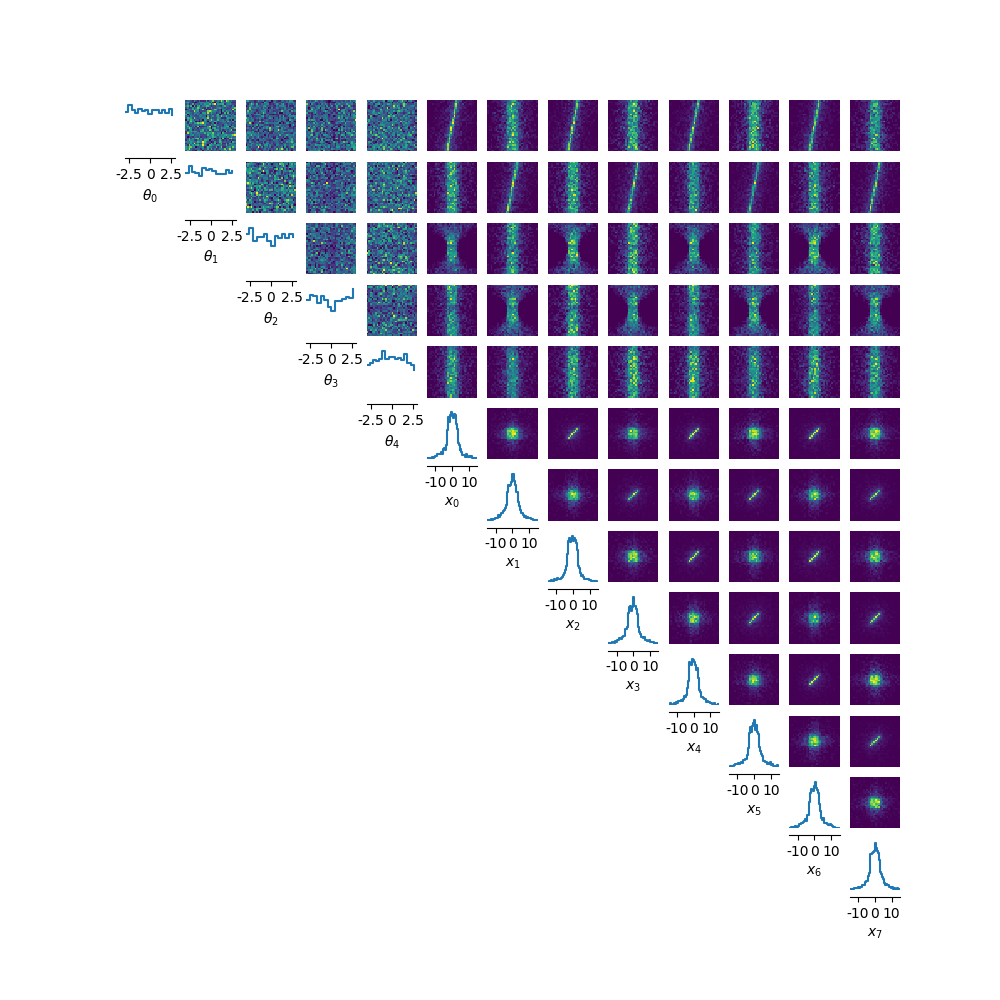

No such comm: ee11c65804034667a3ad6ee4cd6d171e


In [12]:
%matplotlib widget
fig, axes = interactive_pairplot(sample_fn, condition_mask, lowers, uppers,[rf"$\theta_{i}$" for i in range(5)] + [rf"$x_{i}$" for i in range(8)], figsize=(10,10), off_diag_bins=30)

In [13]:
plt.close() # Close the plot to avoid double plotting  